In [11]:
## This Jupyter notebook creates the ICE plot for MDN method

In [12]:
# import packages
import sys
sys.path.append('../../../lib/')
import WDL as wp
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from tensorflow.keras import initializers
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
## plot the figure
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import norm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [13]:
# function definition
def get_mixture_coeff(output, KMIX):
    out_pi, out_sigma, out_mu = tf.split(output, num_or_size_splits=[KMIX]*3, axis=1)
    max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
    out_pi = tf.subtract(out_pi, max_pi)
    out_pi = tf.exp(out_pi) + 1e-5
    normalize_pi = tf.math.reciprocal(tf.reduce_sum(out_pi, 1, keepdims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)
    out_sigma = tf.exp(out_sigma) + 1e-5
    return out_pi, out_sigma, out_mu

def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result, tf.math.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result), tf.math.reciprocal(sigma))

def KLloss(y, output):
    out_pi, out_sigma, out_mu = output
    result = (y - out_mu) / out_sigma
    result = tf.exp(-result ** 2/2) / out_sigma
    result = tf.reduce_sum(result * out_pi, 1, keepdims=True)
    result = -tf.math.log(result + 1e-5)
    return tf.reduce_mean(result)
    
def MixNet(KMIX, n_feature):
    inputs = tf.keras.Input(shape=(n_feature,))
    x = tf.keras.layers.Dense(8, activation=tf.nn.relu, 
                              kernel_initializer=initializers.RandomNormal(stddev=0.01), 
                              bias_initializer=initializers.Zeros())(inputs)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(16, activation=tf.nn.relu, 
                              kernel_initializer=initializers.RandomNormal(stddev=0.01), 
                              bias_initializer=initializers.Zeros())(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(8, activation=tf.nn.relu, 
                              kernel_initializer=initializers.RandomNormal(stddev=0.01),
                              bias_initializer=initializers.Zeros())(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(3*KMIX, kernel_initializer=initializers.RandomNormal(stddev=1),
                              bias_initializer=initializers.RandomNormal(stddev=1))(x)
    out_pi, out_sigma, out_mu = get_mixture_coeff(x, KMIX)
    model = tf.keras.Model(inputs=inputs, outputs=[out_pi, out_sigma, out_mu])
    return model         

def train(X_train, Y_train, X_val, Y_val, lr=1e-1, K = 3,
          max_iter=300, early_stop=True, patience=5):
    model = MixNet(K, X_train.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=KLloss)
    tol = 0 ## early stopping
    if not early_stop:
        patience = max_iter
    loss_train_ = [KLloss(Y_train, model.predict(X_train)).numpy()]
    loss_val_ = [KLloss(Y_val, model.predict(X_val)).numpy()]
    ## start training
    early_exit = False
    for i in range(max_iter):
        with tf.GradientTape() as tape:
            y_pred = model(X_train, training=True)
            loss = KLloss(Y_train, y_pred)
        if np.isnan(loss):
            early_exit = True
            break
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        model.optimizer.apply_gradients(zip(gradients, trainable_vars))
        ## make predictions over validations set
        loss_train = KLloss(Y_train, model.predict(X_train)).numpy()
        loss_val = KLloss(Y_val, model.predict(X_val)).numpy()
        ## early stopping
        if loss_val < loss_val_[-1]:
            tol = 0
        elif early_stop:
            tol += 1
        if tol < patience:
            loss_train_.append(loss_train)
            loss_val_.append(loss_val)
        else:
            early_exit = True
            break
            
    if early_exit:
        iter_best = np.argmin(np.array(loss_val_))
    else:
        iter_best = max_iter
    
    ## return outputs
    outputs = {'iter_best': iter_best, 'model': model, 
               'train_loss': loss_train_, 'val_loss': loss_val_}
    return outputs

In [14]:
# set parameters
#SEED = int(os.getenv('SLURM_ARRAY_TASK_ID'))
SEED = 2020
K = 2
n_dist = 200 ## number of distributions
omega = 0.1 # default 0.1
n_pts = 300

# simulate the data 
np.random.seed(SEED)
X = np.random.uniform(size=(n_dist, 3)) * 2 - 1
Y = np.zeros((n_dist, n_pts))

## simulate Y
for i in range(n_dist):
    mu_1 = X[i, 0]
    mu_2 = 2 * X[i, 1]**2 + 2
    mu_true = [mu_1, mu_2]
    sig_1 = np.abs(X[i, 1]) + 0.5
    sig_2 = np.abs(X[i, 0]) + 0.5
    sig_true = [sig_1, sig_2]
    pi_1 = 1 / (1 + np.exp(X[i, 2]))
    pi_true = [pi_1, 1 - pi_1]
    ## simulate noise
    eps_noise = np.random.normal(loc=0, scale=omega, size=1)
    ## simulate responses
    var_gaussian = np.array([np.random.normal(loc=mu_true[k]+eps_noise, 
                                              scale=sig_true[k], 
                                              size=n_pts) for k in range(K)]).T
    var_mult = np.random.choice(range(K), size=n_pts, replace=True, p=pi_true)
    var_mult = np.eye(K)[var_mult]
    var_GMM = np.sum(var_mult * var_gaussian, axis=1)
    Y[i] = np.sort(var_GMM)

In [15]:
# step 1. train-val split
n_train = int(0.8 * n_dist) 
loc_train = np.random.choice(n_dist, n_train, replace=False)
loc_val = np.setdiff1d(np.arange(n_dist), loc_train)
X_full = np.repeat(X, n_pts, axis=0)
X_train = np.repeat(X[loc_train], n_pts, axis=0)
X_val = np.repeat(X[loc_val], n_pts, axis=0)
Y_full = Y.flatten()
Y_train = Y[loc_train].flatten()
Y_val = Y[loc_val].flatten()
v_center = np.mean(Y_train)
Y_train -= v_center
Y_val -= v_center
Y_full -= v_center

In [16]:
# step 2. model training with early stop
K_mix = 2
lr = 1e-2
n_iter = 1000
y_train = np.tile(np.reshape(Y_train, (-1, 1)), (1, K_mix))
y_val = np.tile(np.reshape(Y_val, (-1, 1)), (1, K_mix))
time_start = datetime.now()
print('Start training:', time_start)
res_init = train(X_train, y_train, X_val, y_val, lr=lr, K = K_mix, 
                 max_iter=n_iter, early_stop=True, patience=5)
print('Time:', datetime.now() - time_start)   

Start training: 2022-06-08 01:28:35.135567
1500/1500 [==============================] - 1s 925us/step


1500/1500 [==============================] - 1s 982us/step


1500/1500 [==============================] - 2s 995us/step


1500/1500 [==============================] - 1s 961us/step


375/375 [==============================] - 0s 966us/step


1500/1500 [==============================] - 1s 911us/step


375/375 [==============================] - 0s 987us/step


1500/1500 [==============================] - 2s 1ms/step


375/375 [==============================] - 0s 1ms/step


1500/1500 [==============================] - 1s 975us/step


375/375 [==============================] - 0s 964us/step


1500/1500 [==============================] - 2s 1ms/step


375/375 [==============================] - 0s 961us/step


1500/1500 [==============================] - 1s 991us/step


375/375 [==============================] - 0s 979us/step
Time: 0:47:55.785377


In [17]:
# step 3. model training with the best number of steps
best_iter = res_init['iter_best']
y_full = np.tile(np.reshape(Y_full, (-1, 1)), (1, K_mix))
res = train(X_full, y_full, X_full, y_full, lr=lr, K = K_mix, 
            max_iter=best_iter, early_stop=False, patience=5)

1875/1875 [==============================] - 2s 869us/step


1875/1875 [==============================] - 2s 982us/step


1875/1875 [==============================] - 2s 1ms/step


1875/1875 [==============================] - 2s 970us/step


1875/1875 [==============================] - 2s 978us/step


1875/1875 [==============================] - 2s 1ms/step


1875/1875 [==============================] - 2s 989us/step


1875/1875 [==============================] - 2s 982us/step


1875/1875 [==============================] - 2s 1ms/step


1875/1875 [==============================] - 2s 894us/step


1875/1875 [==============================] - 2s 902us/step


1875/1875 [==============================] - 2s 971us/step


1875/1875 [==============================] - 2s 1ms/step


1875/1875 [==============================] - 2s 927us/step


1875/1875 [==============================] - 2s 972us/step


In [18]:
# create partial dependence plot
n_evals = 21
q_evals = np.arange(n_evals) / (n_evals-1)
x_eval = np.linspace(-1, 1, n_evals)
X_eval = np.array(np.meshgrid(x_eval, x_eval, x_eval)).T.reshape(-1,3)
p_levs = [0.1, 0.3, 0.5, 0.7, 0.9]
par_mat = np.zeros((3, n_evals, 5))
res_mat =  np.zeros((3, n_evals, 5))
print('Start PDP calculation:', datetime.now())
for i in range(3):
    for j in range(n_evals):
        X_c = X.copy()
        X_c[:, i] = np.quantile(X[:, i], q_evals[j])
        pi_pred, sigma_pred, mu_pred = res['model'].predict(X_c)
        res_mat[i, j] = np.mean([wp.qgmm1d(p_levs, mu_pred[l] + v_center, sigma_pred[l], pi_pred[l]) for l in range(n_dist)], axis=0)
## save the results
#np.save('output/bootstrap_MDN/qt_' + str(SEED).zfill(3) + '.npy', res_mat)
print('Done! Total time:', datetime.now() - time_start) 


Start PDP calculation: 2022-06-08 03:48:57.795152
7/7 [==============================] - 0s 1ms/step
Done! Total time: 2:20:31.576523


In [19]:
q_X = [np.quantile(X[:, i], q_evals) for i in range(3)]

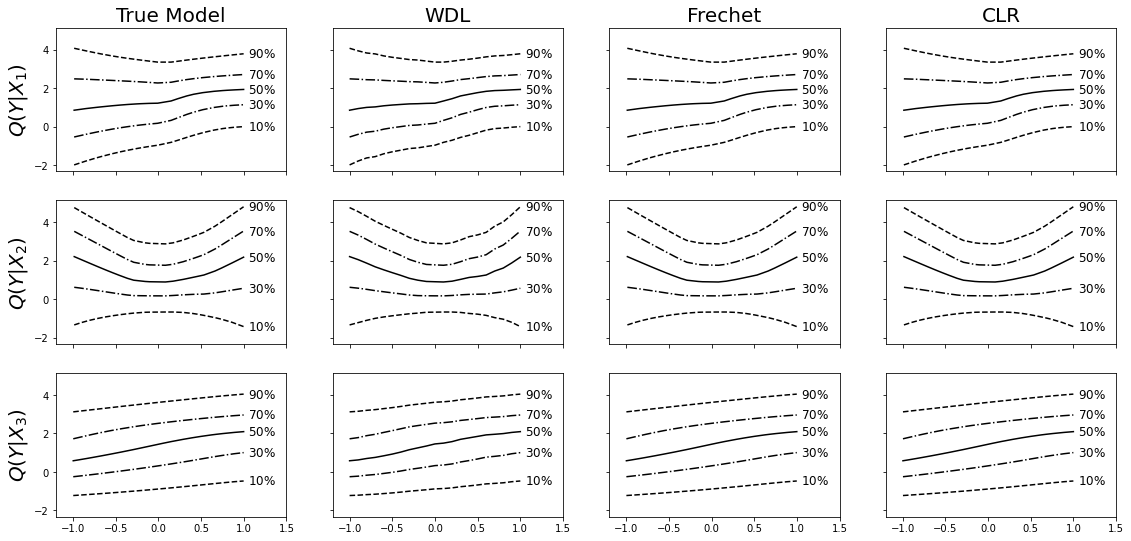

In [20]:
## Ver 1. visualize the partial dependence plot
fig, ax = plt.subplots(3, 4, figsize=(19, 9), sharex=True, sharey=True)
x_eval = np.linspace(-1, 1, 21)
id_var = 0
# plot the partial dependence plot
ax[0, 0].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[0, 0].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[0, 0].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[0, 0].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[0, 0].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
#ax[0, 0].legend()
ax[0, 0].set_title(r'True Model', fontsize=20)
ax[0, 0].set_ylabel(r'$Q(Y|X_1)$', fontsize=20)
ax[0, 0].set_xlim([-1.2, 1.5])
ax[0, 0].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[0, 0].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[0, 0].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[0, 0].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[0, 0].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[0, 1].plot(x_eval, res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[0, 1].plot(x_eval, res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[0, 1].plot(x_eval, res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[0, 1].plot(x_eval, res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[0, 1].plot(x_eval, res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[0, 1].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[0, 1].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[0, 1].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[0, 1].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[0, 1].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)
ax[0, 1].set_title(r'WDL', fontsize=20)


ax[0, 2].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[0, 2].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[0, 2].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[0, 2].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[0, 2].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[0, 2].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[0, 2].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[0, 2].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[0, 2].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[0, 2].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)
ax[0, 2].set_title(r'Frechet', fontsize=20)

ax[0, 3].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[0, 3].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[0, 3].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[0, 3].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[0, 3].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[0, 3].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[0, 3].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[0, 3].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[0, 3].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[0, 3].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)
ax[0, 3].set_title(r'CLR', fontsize=20)

id_var = 1
# plot the partial dependence plot
ax[1, 0].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[1, 0].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[1, 0].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[1, 0].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[1, 0].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
#ax[0, 0].legend()
ax[1, 0].set_ylabel(r'$Q(Y|X_2)$', fontsize=20)
ax[1, 0].set_xlim([-1.2, 1.5])
ax[1, 0].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[1, 0].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[1, 0].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[1, 0].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[1, 0].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[1, 1].plot(x_eval, res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[1, 1].plot(x_eval, res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[1, 1].plot(x_eval, res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[1, 1].plot(x_eval, res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[1, 1].plot(x_eval, res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[1, 1].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[1, 1].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[1, 1].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[1, 1].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[1, 1].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)


ax[1, 2].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[1, 2].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[1, 2].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[1, 2].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[1, 2].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[1, 2].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[1, 2].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[1, 2].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[1, 2].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[1, 2].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[1, 3].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[1, 3].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[1, 3].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[1, 3].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[1, 3].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[1, 3].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[1, 3].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[1, 3].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[1, 3].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[1, 3].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

id_var = 2
# plot the partial dependence plot
ax[2, 0].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[2, 0].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[2, 0].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[2, 0].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[2, 0].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
#ax[0, 0].legend()
ax[2, 0].set_ylabel(r'$Q(Y|X_3)$', fontsize=20)
ax[2, 0].set_xlim([-1.2, 1.5])
ax[2, 0].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[2, 0].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[2, 0].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[2, 0].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[2, 0].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[2, 1].plot(x_eval, res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[2, 1].plot(x_eval, res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[2, 1].plot(x_eval, res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[2, 1].plot(x_eval, res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[2, 1].plot(x_eval, res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[2, 1].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[2, 1].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[2, 1].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[2, 1].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[2, 1].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[2, 2].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[2, 2].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[2, 2].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[2, 2].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[2, 2].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[2, 2].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[2, 2].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[2, 2].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[2, 2].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[2, 2].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

ax[2, 3].plot(q_X[id_var], res_mat[id_var, :, 0], c = 'black', linestyle= '--')
ax[2, 3].plot(q_X[id_var], res_mat[id_var, :, 1], c = 'black', linestyle= '-.')
ax[2, 3].plot(q_X[id_var], res_mat[id_var, :, 2], c = 'black', linestyle= '-')
ax[2, 3].plot(q_X[id_var], res_mat[id_var, :, 3], c = 'black', linestyle= '-.')
ax[2, 3].plot(q_X[id_var], res_mat[id_var, :, 4], c = 'black', linestyle= '--')
ax[2, 3].text(1.05, res_mat[id_var, -1, 0]-0.2, r'$10\%$', fontsize=12)
ax[2, 3].text(1.05, res_mat[id_var, -1, 1]-0.2, r'$30\%$', fontsize=12)
ax[2, 3].text(1.05, res_mat[id_var, -1, 2]-0.2, r'$50\%$', fontsize=12)
ax[2, 3].text(1.05, res_mat[id_var, -1, 3]-0.2, r'$70\%$', fontsize=12)
ax[2, 3].text(1.05, res_mat[id_var, -1, 4]-0.2, r'$90\%$', fontsize=12)

#plt.savefig('../../../output/fig_03.pdf', bbox_inches='tight')  
plt.show()

In [ ]:
x_eval = np.linspace(-1, 1, 21)

In [ ]:
id_var = 0
plt.plot(x_eval, res_mat[id_var, :, 4])

In [ ]:
res_mat.shape